In [135]:
import numpy as np
import scipy.stats as stats
import time
import msprime
import matplotlib.pyplot as plt
from multiprocessing import Pool
import itertools
import pandas as pd
import pickle
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [134]:
@np.vectorize
def bgs_rec(mu, s, r, L):
    return np.exp(-L * mu/(s*(1+(1-s)*r/s)**2))

def MAE(

## Noise in Pairwise Diversity

If we care about simulating some process and learning about some parameter from the observed $T_2$s (or some function of them), we need to get sense of the noise around $\pi$ and $T_2$. According to Tajima (1983), the variance in $\pi$ is:

$$\text{Var}(\pi) = \frac{n + 1}{3(n-1)} \theta + \frac{2(n^2 + n + 3)}{9n(n-1)}\theta^2$$

In the limit as $n \to \infty$, $\text{Var} = \frac{1}{9}(3 \theta + 2 \theta^2)$. The first term is the sampling variation, the second is the evolutionary variation. 

Does this theory check out?

In [268]:
N = 1000
ns = [2, 4, 6, 10, 20, 30, 40] + np.arange(50, N, 100).tolist()

In [273]:
y = [np.var([msprime.sim_ancestry(n, population_size=N).diversity(mode='branch')/(4*N) for _ in range(1000)]) for n in ns]

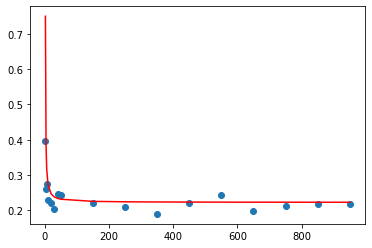

In [464]:
def taj83_var(n, theta):
    return (n+1)/(3*(n-1))*theta + 2*(n**2 + n + 3)/(9*n*(n-1)) * theta**2
plt.scatter(ns, y)
plt.plot(ns, taj83_var(np.array(ns), 1/2), c='r')

Recall, branch-mode diversity returns $T_2$ in units of 4N, e.g. if $\mu = 1$:

In [463]:
np.mean([msprime.sim_ancestry(100, population_size=1000).diversity(mode='branch')/(4*1000) for _ in range(1000)])

1.026909460669142

## Estimating B

If we're using branch statistics, our only source of variation is evolutionary variation. The pairwise coalescent time $T_2 \sim \text{Exp}(1/2N)$, such that $\text{E}(T_2) = 2N$ and $\text{Var}(T_2) = 4N^2$.

We imagine some fixed scalar $B$ rescales $N$; we wish to estimate this from $s$ observed trees using $\bar{B} = 1/s \sum_i^s T_2(i)/2N$. $\mathrm{E}(\bar{B}) = 2BN/2N = B$ so this is an unbiased estimator of $B$. $\mathrm{Var}(\bar{B}) = \frac{s \mathrm{Var}(T_2)}{4 s^2 N^2}  = \frac{4B^2N^2s}{4 s^2 N^2} = B^2/s$.

**Importantly**, note that this *ignores* the process noise due to selection; in reality $B$ itself is a random variable. However, selection may decrease $\mathrm{Var}(T_2)$.

Below I simulate this: each run draws $s$ sample trees, calculates $\hat{B}$ for each tree, and average them to get $\bar{B}$. I then consider the variance of these $\bar{B}$s.

In [297]:
N = 1000
B_array = np.linspace(0.1, 1, 10)
s_array = [2, 5, 10, 50, 100]
n_array = [N]
N_array = [N]
rep_array = np.arange(1000)
params = list(itertools.product(B_array, s_array, n_array, N_array, rep_array))
param_grid = np.array(params)

def runner(param):
    B, s, n, N, rep = param
    sims = np.array([msprime.sim_ancestry(n, population_size=B*N).diversity(mode='branch')/(4*N) for _ in range(s)])
    return sims.mean(), sims.var()

with Pool(70) as p:
    res = np.array(p.map(runner, params))

In [377]:
d = pd.DataFrame(np.concatenate((param_grid, res[:, 0][:, None]), axis=1))
d.columns = ['B', 's', 'n', 'N', 'rep', 'Bhat']
d.head()

,B,s,n,N,rep,Bhat
0,0.1,2.0,1000.0,1000.0,0.0,0.059737
1,0.1,2.0,1000.0,1000.0,1.0,0.064928
2,0.1,2.0,1000.0,1000.0,2.0,0.108950
3,0.1,2.0,1000.0,1000.0,3.0,0.076978
4,0.1,2.0,1000.0,1000.0,4.0,0.096129


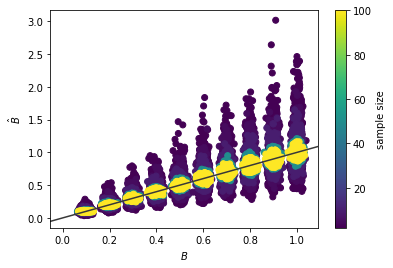

In [455]:
def jitter(x, var=0.01):
    return x + np.random.normal(0, var, len(x))

fig, ax = plt.subplots()
cax = ax.scatter(jitter(d['B']), d['Bhat'], c=d['s'], alpha=1)
ax.axline((0, 0), slope=1, c='0.22')
ax.set_xlabel('$B$')
ax.set_ylabel('$\hat{B}$')
plt.colorbar(cax, label='sample size')

In [395]:
ds = d.groupby(['B', 's', 'n', 'N']).agg([np.mean, np.var]).reset_index()
ds.columns = ["_".join(x) if len(x[1]) > 0 else x[0] for x in ds.columns]
ds.head()

,B,s,n,N,rep_mean,rep_var,Bhat_mean,Bhat_var
0,0.1,2.0,1000.0,1000.0,499.5,83416.666667,0.100114,0.001105
1,0.1,5.0,1000.0,1000.0,499.5,83416.666667,0.099060,0.000447
2,0.1,10.0,1000.0,1000.0,499.5,83416.666667,0.100330,0.000226
3,0.1,50.0,1000.0,1000.0,499.5,83416.666667,0.100451,0.000047
4,0.1,100.0,1000.0,1000.0,499.5,83416.666667,0.099921,0.000021


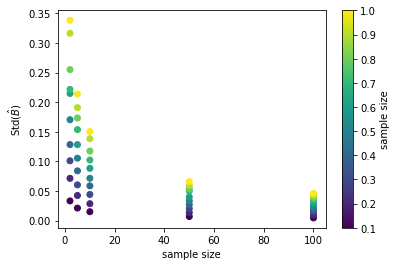

In [451]:
fig, ax = plt.subplots()
cax = ax.scatter(ds['s'], np.sqrt(ds['Bhat_var']), c=ds['B'])
ax.set_ylabel("$\mathrm{Std}(\hat{B})$")
ax.set_xlabel("sample size")
plt.colorbar(cax, label='sample size')

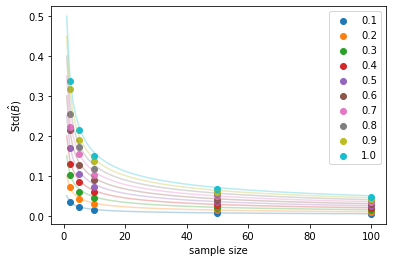

In [ ]:
fig, ax = plt.subplots()
sx = np.arange(1, 100)
for b in B_array:
    dx = ds.loc[ds['B'] == b]
    c = ax.scatter(dx['s'], np.sqrt(dx['Bhat_var']), label=np.round(b, 2))
    ax.plot(sx, b*np.sqrt(0.25/sx), alpha=0.3)
ax.set_ylabel("$\mathrm{Std}(\hat{B})$")
ax.set_xlabel("sample size")
ax.legend()

Note that our theory works well, even though we're not conditioning on genealogies, but just imagining averaging over independent coalescent pairs to get $T_2$. This is because as the first section showed, the vast majority of the noise is from the evolutionary process itself.

## Learning B

In [551]:
mu_array = 1000 * 10**np.linspace(-3, -2, 10)
s_arrray = 10**np.linspace(-6, -3, 10)
N_array = [100, 1000]
nreps_array = [100]

In [552]:
bgs_params = list(itertools.product(mu_array, s_array, N_array, nreps_array))
bgs_param_grid = np.array(bgs_params)

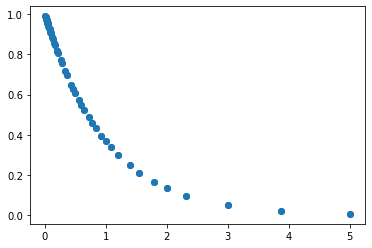

In [553]:
plt.scatter(bgs_param_grid[:, 0]/bgs_param_grid[:, 1], np.exp(-bgs_param_grid[:, 0]/bgs_param_grid[:, 1]))

In [554]:
def bgs_runner(param):
    mu, s, N, nreps = param
    B = np.exp(-mu/s)
    Bhats = np.array([msprime.sim_ancestry(N, population_size=B*N).diversity(mode='branch')/(4*N) for _ in range(nreps)])
    return Bhats.mean()

with Pool(70) as p:
    res = np.array(p.map(bgs_runner, bgs_params))

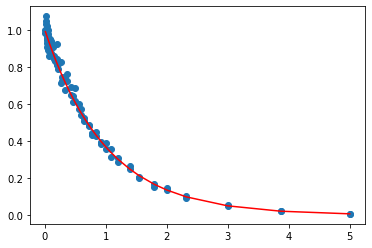

In [555]:
fig, ax = plt.subplots()
ax.scatter(bgs_param_grid[:, 0]/bgs_param_grid[:, 1], res)
rate = np.sort(bgs_param_grid[:, 0]/bgs_param_grid[:, 1])
ax.plot(rate, np.exp(-rate), c='r')
#ax.set_yscale('log')

In [ ]:
plt.scatter(bgs_param_grid[:, 0]/bgs_param_grid[:, 1], res)
rate = np.sort(bgs_param_grid[:, 0]/bgs_param_grid[:, 1])
plt.plot(rate, np.exp(-rate), c='r')

## BGS with Recombination

Note the mutation rates here are somewhat realistic, but still too high for the deleterious mutation rate. The analytic BGS function predicts small local reductions in $B$, but in terms of existing inference approaches, these only become sizeable in aggregate. Thus learning a local B function is extremely hard, as:

1. Noise is highest when $B$ is largest. 
2. Changes in $B$ are very small when looking at local features.
3. A learned function $\tilde{B}$ that's noisy is potentially bad, as $B$ is *multiplicative* across segments under purifying selection.

In [667]:
mu_array = np.linspace(1e-8, 1e-7, 10)
s_arrray = np.linspace(1e-5, 1e-1, 10)
#r_arrray = 10**np.linspace(-6, -2, 10)
r_arrray = [1e-8]
N_array = [1000]
L_arrray = [10_000, 100_000, 1_000_000]
nreps_array = [5]

In [668]:
bgs_rec_params = list(itertools.product(mu_array, s_array, r_arrray, N_array, L_arrray, nreps_array))
bgs_rec_param_grid = np.array(bgs_rec_params)

In [669]:
def bgs_rec_runner(param):
    mu, s, r, N, L, nreps = param
    B = bgs_rec(mu, s, r, L)
    Bhats = np.array([msprime.sim_ancestry(N, population_size=B*N).diversity(mode='branch')/(4*N) 
                      for _ in range(nreps)])
    return Bhats.mean()

with Pool(70) as p:
    bgs_rec_res = np.array(p.map(bgs_rec_runner, bgs_rec_params))

In [676]:
np.mean([msprime.sim_ancestry(100, population_size=1000, ploidy=1).diversity(mode='branch') 
                      for _ in range(1000)])

1994.080124389312

Text(0.5, 0, '$L \\mu / s$')

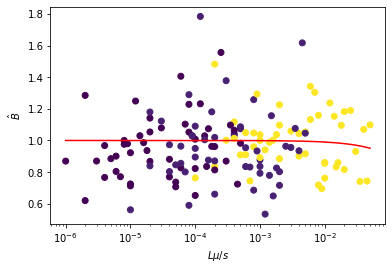

In [670]:
fig, ax = plt.subplots()
ax.scatter(bgs_rec_param_grid[:, 4]*bgs_rec_param_grid[:, 0]/bgs_rec_param_grid[:, 1], bgs_rec_res, c=bgs_rec_param_grid[:, 4])
rate = bgs_rec_param_grid[:, 4]*bgs_rec_param_grid[:, 0]/bgs_rec_param_grid[:, 1]
idx = np.argsort(rate)
y = bgs_rec(bgs_rec_param_grid[:, 0], bgs_rec_param_grid[:, 1], bgs_rec_param_grid[:, 2], bgs_rec_param_grid[:, 4])
ax.plot(rate[idx], y[idx], c='r')
ax.set_xscale('log')
ax.set_ylabel('$\hat{B}$')
ax.set_xlabel('$L \mu / s$')

In [666]:
np.prod(bgs_rec(1e-8, 1e-2, 1e-2, 1000)**1000)

0.7768415492061416

### Support Vector Regression

`params` is a matrix with columns:

```
0   1  2  3  4  5
mu  s  r  N  L  nreps
```

In [21]:
with open('../msprime_sims/bgs_rec.pkl', 'rb') as f:
    params, bhats = pickle.load(f)
X = np.array(params)
y = np.log10(np.array(bhats).mean(axis=1))

In [23]:
def normalize(x):
    return ((x - x.mean(axis=0)) / x.std(axis=0))

In [29]:
Xn = normalize(X[:, (0, 1, 4)])
yn = normalize(y)

In [86]:
with open('../msprime_sims/bgs_rec_svr_test.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test, X_scaler, svr_fit = pickle.load(f)

/home/vsb/miniconda3/envs/bgcls/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/vsb/miniconda3/envs/bgcls/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVR from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [119]:
X_test_unscaled = X_scaler.inverse_transform(X_test)

In [87]:
yhat = svr_fit.predict(X_test)

### Out sample prediction

Here I'm comparing $y_\mathrm{test}$ (observed $\pi/4N\mu$ from simulations, which is $\hat{B}$) with the *predicted* out-sample $\hat{y}$ from the test data $X_\mathrm{train}$.

Text(0.5, 0, '$y$')

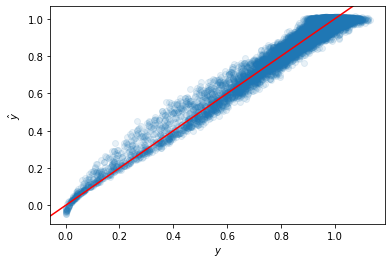

In [88]:
fig, ax = plt.subplots()
ax.scatter(y_test, yhat, alpha=0.1)
ax.axline((0, 0), slope=1, c='r')
ax.set_ylabel("$\hat{y}$")
ax.set_xlabel("$y$")

There seems to be something strange happening at the top — zooming in we see a lot of noise and a bad fit around $B \approx 1$.

Text(0.5, 0, '$y$')

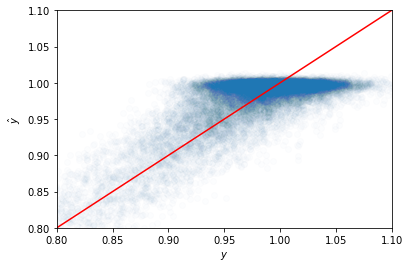

In [89]:
fig, ax = plt.subplots()
ax.scatter(y_test, yhat, alpha=0.01)
ax.axline((0, 0), slope=1, c='r')
#ax.set_yscale('log')
#ax.set_xscale('log')
c = 0.8
ax.set_ylim(c, 1.1)
ax.set_xlim(c, 1.1)
ax.set_ylabel("$\hat{y}$")
ax.set_xlabel("$y$")

How does relative error look across $y_\mathrm{test}$?

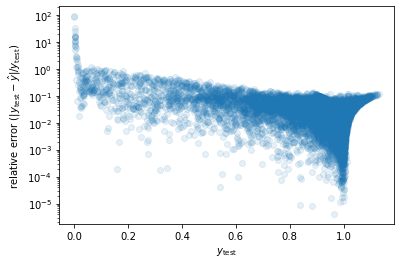

In [165]:
fig, ax = plt.subplots()
ax.scatter(y_test, np.abs(y_test - yhat)/y_test, alpha=0.11)
ax.set_ylabel("relative error ($|y_\mathrm{test} - \hat{y}| / y_\mathrm{test})$")
ax.set_xlabel("$y_\mathrm{test}$")
ax.set_yscale('log')
#ax.set_title(f"MAE = {np.round(np.mean(np.abs(y_theory-yhat)), 4)}")

Another test is to compare $B(\mu, s, r, L)$, the analytic $B$ for the set of parameters in $X_\mathrm{test}$ (inverse-transformed through the scaling function) to the predicted $\hat{y}$. This is something we can do because we know the explicit functional form of $B(\mu, s, r, L)$ (we won't have this with the full weak selection regime).

Text(0.5, 1.0, 'MAE = 0.0098, MAPE = 0.0375')

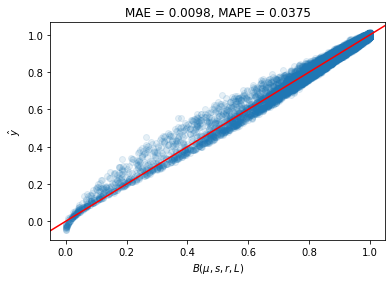

In [158]:
y_theory = bgs_rec(X_test_unscaled[:, 0], X_test_unscaled[:, 1], 1e-8, X_test_unscaled[:, 2])
fig, ax = plt.subplots()
ax.scatter(y_theory, yhat, alpha=0.11)
ax.axline((0, 0), slope=1, c='r')
ax.set_ylabel("$\hat{y}$")
ax.set_xlabel("$B(\mu, s, r, L)$")
ax.set_title(f"MAE = {np.round(mean_absolute_error(y_theory, yhat), 4)}, "
             f"MAPE = {np.round(mean_absolute_percentage_error(y_theory, yhat), 4)}")

What does MAE look like across $B$?

Text(0.5, 0, 'BGS theory B')

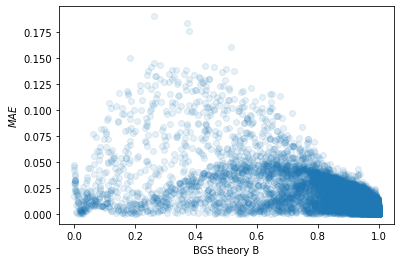

In [156]:
y_theory = bgs_rec(X_test_unscaled[:, 0], X_test_unscaled[:, 1], 1e-8, X_test_unscaled[:, 2])
fig, ax = plt.subplots()
ax.scatter(y_theory, np.abs(y_theory-yhat), alpha=0.11)
ax.set_ylabel("$MAE$")
ax.set_xlabel("BGS theory B")
#ax.set_title(f"MAE = {np.round(np.mean(np.abs(y_theory-yhat)), 4)}")

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, np.abs(y_test - yhat)/y_test, alpha=0.11)
ax.set_ylabel("relative error ($|y_\mathrm{test} - \hat{y}| / y_\mathrm{test})$")
ax.set_xlabel("$y_\mathrm{test}$")
ax.set_yscale('log')
#ax.set_title(f"MAE = {np.round(np.mean(np.abs(y_theory-yhat)), 4)}")

Text(0.5, 0, '$y$')

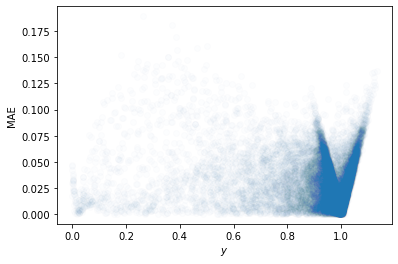

In [92]:
fig, ax = plt.subplots()
ax.scatter(y_test, np.abs(y_test-yhat), alpha=0.01)
ax.set_ylabel("MAE")
ax.set_xlabel("$y$")

In [95]:
svr_fit

SVR(C=10, cache_size=40000, epsilon=0.001, verbose=True)

In [ ]:
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.01)

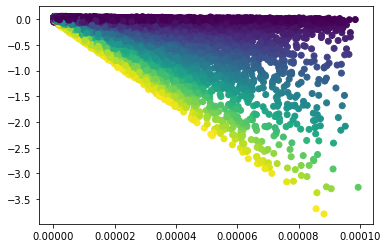

In [28]:
plt.scatter(params[:, 0]/params[:, 1], np.log10(bhats.mean(axis=1)), c = params[:, 4])

In [ ]:
fit_rbf = svr_rbf.fit(X_test, y_test)
yhat_rbf = fit_rbf.predict(params)


In [ ]:
@np.vectorize
def bgs_rec(mu, s, r, L):
    return np.exp(-L * mu/(s*(1+(1-s)*r/s)**2))


In [12]:
params.shape

(100000, 6)

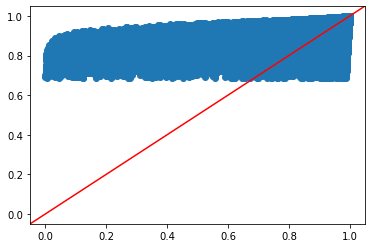

In [18]:
fig, ax = plt.subplots()
ax.scatter(bgs_rec(params[:, 0], params[:, 1], params[:, 2], params[:, 4]), yhat_rbf)
ax.axline((0, 0), slope=1, c='r')

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
X_train.shape

(50000, 6)

In [16]:
def network():
    ## build network
    model=keras.Sequential()
    model.add(tf.keras.Input(shape=(5,)))
    for i in range(4):
        model.add(tf.keras.layers.Dense(64,activation='elu'))
    for i in range(4):
        model.add(tf.keras.layers.Dense(32,activation='elu'))
    model.add(tf.keras.layers.Dense(1, activation='elu'))
    model.compile(
        optimizer='Adam',
        loss=tf.keras.losses.MeanSquaredError(),
        weighted_metrics=['MeanSquaredError'],
        )
    return model

# ## Train network on unbiased data
train_xy = X_train[:, 0:5]
train_z = y_train
for i in range(3):
    model = network()
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)
    history = model.fit(train_xy, train_z, validation_split=0.1, batch_size=32,epochs=500, verbose=0, callbacks=[es])

  

Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping


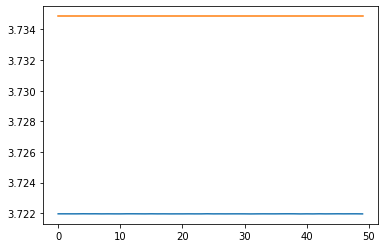

In [18]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'][1:], label='loss')
ax.plot(history.history['val_loss'][1:], label='val_loss')

In [25]:
model.predict(X_train[:, :5].T)

InvalidArgumentError:  Matrix size-incompatible: In[0]: [5,50000], In[1]: [5,64]
	 [[node sequential_5/dense_45/Elu (defined at tmp/ipykernel_56035/4018244900.py:1) ]] [Op:__inference_predict_function_509370]

Function call stack:
predict_function


In [ ]:
  # evaluate fit
    xtest = np.random.uniform(0, 10, 1000)
    ytest = np.random.uniform(0, 10, 1000)
    test_xy = np.stack((xtest, ytest), axis=1)

    predict=model.predict(test_xy)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.scatter(xtest, ytest, c=np.abs(predict.flatten() - zfn(xtest, ytest)))
    
    ax2.legend()
    print(model.evaluate(test_xy, zfn(xtest, ytest)))

## Random Forests

In [ ]:
model = RandomForestRegressor(n_estimators = 200)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, params, bhats, scoring='explained_variance', cv=cv, n_jobs=-1, error_score='raise')
print('explained variance: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))